In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import matplotlib as mpl

# import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pdf2image import convert_from_path

import madness_benchmark.boxplot
from madness_benchmark.utils import get_benchmark_config_path

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200

# plt.rcParams[
#     "text.latex.preamble"
# ] = r"\usepackage{bm} \usepackage{amsmath}"  # for \text command

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config = yaml.safe_load(f)
survey = galcheat.get_survey(benchmark_config["survey_name"])

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)


def format_func(value, tick_number):
    # Format the y-axis labels as integers without decimals
    return "{:.3f}".format(value)

In [ ]:
density_level = "high"

data_path = os.path.join(
    benchmark_config["RESULTS_PATH"][benchmark_config["survey_name"]],
    density_level + "_density",
)
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

In [ ]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
outlier_contamination_value = 5
mask = madness_results["r_contamination"] <= outlier_contamination_value
print(f"outlier contamination cut: {outlier_contamination_value}")
print(f"using only {np.sum(mask)} out of {len(madness_results)}")
print(f"removed {len(madness_results) - np.sum(mask)} galaxies")
madness_abs_relflux_avg = np.mean(
    np.abs(
        madness_results["r_phot_flux"].values[mask]
        / actual_photometry["r_phot_flux"].values[mask]
        - 1
    )
)
scarlet_abs_relflux_avg = np.mean(
    np.abs(
        scarlet_results["r_phot_flux"].values[mask]
        / actual_photometry["r_phot_flux"].values[mask]
        - 1
    )
)
debvader_abs_relflux_avg = np.mean(
    np.abs(
        debvader_results["r_phot_flux"].values[mask]
        / actual_photometry["r_phot_flux"].values[mask]
        - 1
    )
)
blended_abs_relflux_avg = np.mean(
    np.abs(
        blended_photometry["r_phot_flux"].values[mask]
        / actual_photometry["r_phot_flux"].values[mask]
        - 1
    )
)

outlier contamination cut: 5
using only 94893 out of 95972
removed 1079 galaxies


In [ ]:
print("Average relative flux residual percentages")
print(f"blended: {blended_abs_relflux_avg*100}")
print(f"madness: {madness_abs_relflux_avg*100}")
print(f"scarlet: {scarlet_abs_relflux_avg*100}")
print(f"debvader: {debvader_abs_relflux_avg*100}")

Average relative flux residual percentages
blended: 14.19917689756954
madness: 1.9716906593345822
scarlet: 2.7819274430843195
debvader: 3.9148731561331496


In [ ]:
print(
    f"percentage improvement over scarlet: {(scarlet_abs_relflux_avg - madness_abs_relflux_avg) * 100 / scarlet_abs_relflux_avg}"
)
print(
    f"percentage improvement over debvader: {(debvader_abs_relflux_avg - madness_abs_relflux_avg) * 100 / debvader_abs_relflux_avg}"
)

percentage improvement over scarlet: 29.12501495191509
percentage improvement over debvader: 49.63589928205779


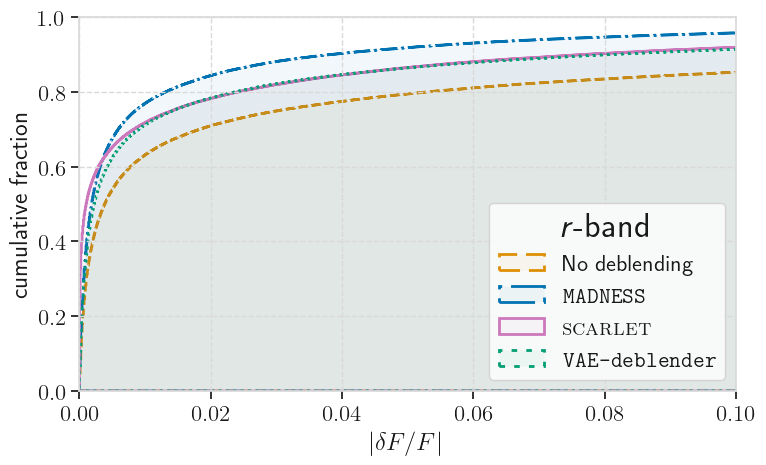

In [ ]:
sns.set_theme(
    font_scale=1.5,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)

band = "r"

plt.figure(figsize=(8, 5))
bins = np.arange(-1, 1, 0.0001)
#     mask = (
#         actual_photometry[band + "_phot_flux"].values
#         / actual_photometry[band + "_phot_fluxerrs"].values
#     ) > 10

mask = np.ones(len(madness_results), dtype=bool)

sns.histplot(
    np.abs(
        blended_photometry[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=blended_plot_color,
    ls=blended_plot_ls,
    linewidth=2,
    element="step",
    label="No deblending",
)

x = sns.histplot(
    np.abs(
        madness_results[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=madness_plot_color,
    element="step",
    ls=madness_plot_ls,
    linewidth=2,
    label=madness_plot_label,
)
# plt.plot([], [], ls=madness_plot_ls, lw=2, color=madness_plot_color, label=madness_plot_label)

sns.histplot(
    np.abs(
        scarlet_results[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=scarlet_plot_color,
    element="step",
    linewidth=2,
    ls=scarlet_plot_ls,
    label=scarlet_plot_label,
)
# plt.plot([], [], ls=scarlet_plot_ls, lw=2, color=scarlet_plot_color, label=scarlet_plot_label)

# plt.plot([], [], ls=blended_plot_ls, lw=2, color=blended_plot_color, label="blended")

sns.histplot(
    np.abs(
        debvader_results[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=debvader_plot_color,
    element="step",
    ls=debvader_plot_ls,
    linewidth=2,
    label=debvader_plot_label,
)
# plt.plot([], [], ls=debvader_plot_ls, lw=2, color=debvader_plot_color, label=debvader_plot_label)

ax = plt.gca()
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
# ax.grid(color='lightgray', linestyle='-', linewidth=2)
plt.xlim([0, 0.1])
plt.ylim([0.0, 1])
plt.xlabel(r"$|\delta F/F|$")
plt.ylabel("cumulative fraction")


plt.legend(loc="lower right", title_fontsize=20)
plt.tight_layout()
plt.savefig(
    os.path.join(
        "results",
        f"cumulative_distib_phot_err_{band}.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)

plt.legend(title=rf"\textit{{{band}}}-band", loc="lower right", title_fontsize=25)


plt.show()

plt.close()

# Plot for only slightly blended galaxies

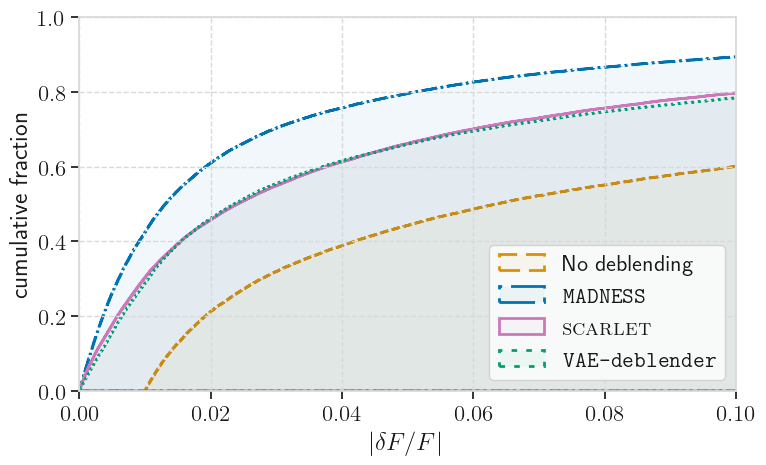

In [ ]:
band = "r"

sns.set_theme(
    font_scale=1.5,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)
plt.figure(figsize=(8, 5))
bins = np.arange(-1, 1, 0.0001)
#     mask = (
#         actual_photometry[band + "_phot_flux"].values
#         / actual_photometry[band + "_phot_fluxerrs"].values
#     ) > 10

mask = madness_results["r_contamination"] >= 0.01

sns.histplot(
    np.abs(
        blended_photometry[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=blended_plot_color,
    ls=blended_plot_ls,
    linewidth=2,
    element="step",
    label="No deblending",
)

x = sns.histplot(
    np.abs(
        madness_results[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=madness_plot_color,
    element="step",
    ls=madness_plot_ls,
    linewidth=2,
    label=madness_plot_label,
)
# plt.plot([], [], ls=madness_plot_ls, lw=2, color=madness_plot_color, label=madness_plot_label)

sns.histplot(
    np.abs(
        scarlet_results[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=scarlet_plot_color,
    element="step",
    linewidth=2,
    ls=scarlet_plot_ls,
    label=scarlet_plot_label,
)
# plt.plot([], [], ls=scarlet_plot_ls, lw=2, color=scarlet_plot_color, label=scarlet_plot_label)

# plt.plot([], [], ls=blended_plot_ls, lw=2, color=blended_plot_color, label="blended")

sns.histplot(
    np.abs(
        debvader_results[band + "_phot_flux"].values[mask]
        / actual_photometry[band + "_phot_flux"].values[mask]
        - 1
    ),
    bins=bins,
    stat="density",
    alpha=0.05,
    cumulative=True,
    color=debvader_plot_color,
    element="step",
    ls=debvader_plot_ls,
    linewidth=2,
    label=debvader_plot_label,
)
# plt.plot([], [], ls=debvader_plot_ls, lw=2, color=debvader_plot_color, label=debvader_plot_label)

ax = plt.gca()
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
# ax.grid(color='lightgray', linestyle='-', linewidth=2)
plt.xlim([0, 0.1])
plt.ylim([0.0, 1])
plt.xlabel(r"$|\delta F/F|$")
plt.ylabel("cumulative fraction")

plt.legend(loc="lower right", title_fontsize=20)
plt.tight_layout()
plt.savefig(
    os.path.join(
        "results",
        "cumulative_distib_phot_err_" + band + "_contamination_cut" + ".pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)

plt.show()

plt.close()

## Box plots

### SNR

In [ ]:
boxplot_snr_df = {}

r_snr_mask = (
    actual_photometry["r_phot_flux"].values
    / actual_photometry["r_phot_fluxerrs"].values
) > 5

boxplot_snr_df["snr"] = list(madness_results["r_band_snr"][r_snr_mask])
boxplot_snr_df["type"] = ["madness"] * len(madness_results[r_snr_mask])
# boxplot_snr_df["r_relative_flux_err"] = list(madness_relative_difference)
boxplot_snr_df["r_relative_flux_err"] = list(
    np.abs(
        madness_results["r_phot_flux"].values[r_snr_mask]
        - actual_photometry["r_phot_flux"].values[r_snr_mask]
    )
    / actual_photometry["r_phot_flux"].values[r_snr_mask]
)


boxplot_snr_df["snr"].extend(list(debvader_results["r_band_snr"][r_snr_mask]))
boxplot_snr_df["type"].extend(["vae_deblender"] * len(debvader_results[r_snr_mask]))
boxplot_snr_df["r_relative_flux_err"].extend(
    list(
        np.abs(
            debvader_results["r_phot_flux"].values[r_snr_mask]
            - actual_photometry["r_phot_flux"].values[r_snr_mask]
        )
        / actual_photometry["r_phot_flux"].values[r_snr_mask]
    )
)

boxplot_snr_df = pd.DataFrame(boxplot_snr_df)

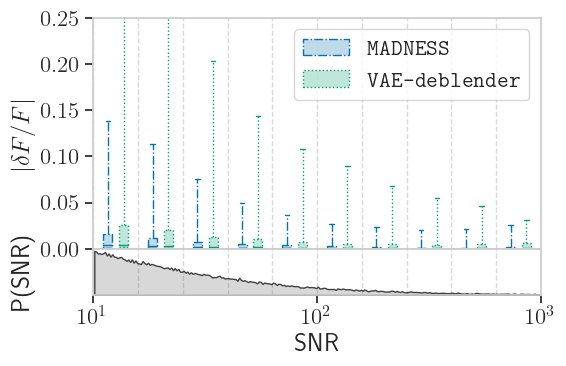

In [ ]:
(
    fig,
    median_fluxerr,
    q1_fluxerr,
    q3_fluxerr,
    whislo_fluxerr,
    whishi_fluxerr,
) = madness_benchmark.boxplot.boxplot_func(
    boxplot_snr_df,
    x="snr",
    y="r_relative_flux_err",
    z="type",
    xlim=(10, 1000),
    ylim=(0, 0.25),
    x_scale="log",
    legend=[madness_plot_label, debvader_plot_label],
    x_label="SNR",
    y_label=r"$|\delta F/ F|$",
    y_label_hist="P(SNR)",
    legend_remove=False,
    legend_location="upper right",
    #     x_ticks=[10, 20, 30, 40, 60, 100],
    #     x_ticklabels=[r'$10$', r'$20$', r'$30$', r'$40$', r'$60$', r'$100$'],
    whis=[5, 95],
    percents=[25, 75],
    palette=[madness_plot_color, debvader_plot_color],  # 0.35,
    ls=[madness_plot_ls, debvader_plot_ls],
    nbins=10,
    x_major_grid=True,
    sns_font_scale=1.5,
)

plt.savefig(os.path.join("results", "temp", "snr_box_plot.pdf"), dpi=1200)

### Blendedness and Contamination

In [ ]:
boxplot_blendedness_df = {}

boxplot_blendedness_df["r_blendedness"] = list(
    madness_results["r_blendedness"][r_snr_mask]
)
boxplot_blendedness_df["r_contamination"] = list(
    madness_results["r_contamination"][r_snr_mask]
)
boxplot_blendedness_df["type"] = ["madness"] * len(madness_results[r_snr_mask])
boxplot_blendedness_df["r_relative_flux_err"] = list(
    np.abs(
        madness_results["r_phot_flux"].values[r_snr_mask]
        - actual_photometry["r_phot_flux"].values[r_snr_mask]
    )
    / actual_photometry["r_phot_flux"].values[r_snr_mask]
)


boxplot_blendedness_df["r_blendedness"].extend(
    list(debvader_results["r_blendedness"][r_snr_mask])
)
boxplot_blendedness_df["r_contamination"].extend(
    list(madness_results["r_contamination"][r_snr_mask])
)
boxplot_blendedness_df["type"].extend(
    ["vae_deblender"] * len(debvader_results[r_snr_mask])
)
boxplot_blendedness_df["r_relative_flux_err"].extend(
    list(
        np.abs(
            debvader_results["r_phot_flux"].values[r_snr_mask]
            - actual_photometry["r_phot_flux"].values[r_snr_mask]
        )
        / actual_photometry["r_phot_flux"].values[r_snr_mask]
    )
)

boxplot_blendedness_df = pd.DataFrame(boxplot_blendedness_df)

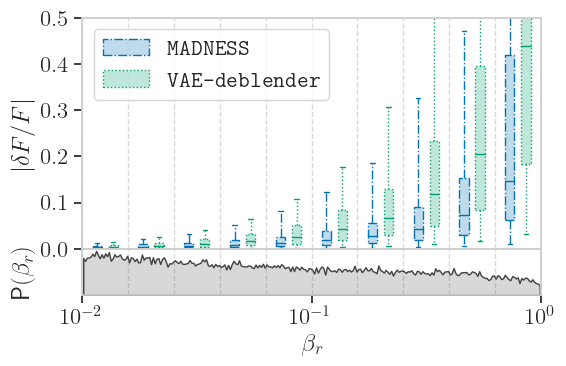

In [ ]:
(
    fig,
    median_shear,
    q1_shear,
    q3_shear,
    whislo_shear,
    whishi_shear,
) = madness_benchmark.boxplot.boxplot_func(
    boxplot_blendedness_df,
    x="r_blendedness",
    y="r_relative_flux_err",
    z="type",
    xlim=(1e-2, 1),
    ylim=(-0, 0.5),
    x_scale="log",
    legend=[madness_plot_label, debvader_plot_label],
    x_label=r"$\beta_r$",
    y_label=r"$|\delta F / F|$",
    y_label_hist=r"P$(\beta_r)$",
    legend_remove=False,
    whis=[5, 95],
    percents=[25, 75],
    palette=[madness_plot_color, debvader_plot_color],  # 0.35,
    ls=[madness_plot_ls, debvader_plot_ls],
    nbins=10,
    x_major_grid=True,
    sns_font_scale=1.5,
)
plt.savefig(os.path.join("results", "temp", "blendedness_box_plot.pdf"))

### Contamination

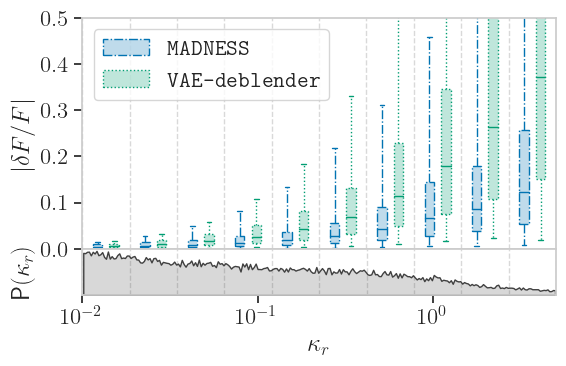

In [ ]:
(
    fig,
    median_shear,
    q1_shear,
    q3_shear,
    whislo_shear,
    whishi_shear,
) = madness_benchmark.boxplot.boxplot_func(
    boxplot_blendedness_df,
    x="r_contamination",
    y="r_relative_flux_err",
    z="type",
    xlim=(1e-2, 5),
    ylim=(0, 0.5),
    x_scale="log",
    legend=[madness_plot_label, debvader_plot_label],
    x_label=r"$\kappa_r$",
    y_label=r"$|\delta F/F|$",
    y_label_hist=r"P$(\kappa_r)$",
    legend_remove=False,
    whis=[5, 95],
    percents=[25, 75],
    palette=[madness_plot_color, debvader_plot_color],  # 0.35,
    ls=[madness_plot_ls, debvader_plot_ls],
    nbins=10,
    sns_font_scale=1.5,
)
plt.savefig(os.path.join("results", "temp", "contamination_box_plot.pdf"))

### Combine the plots

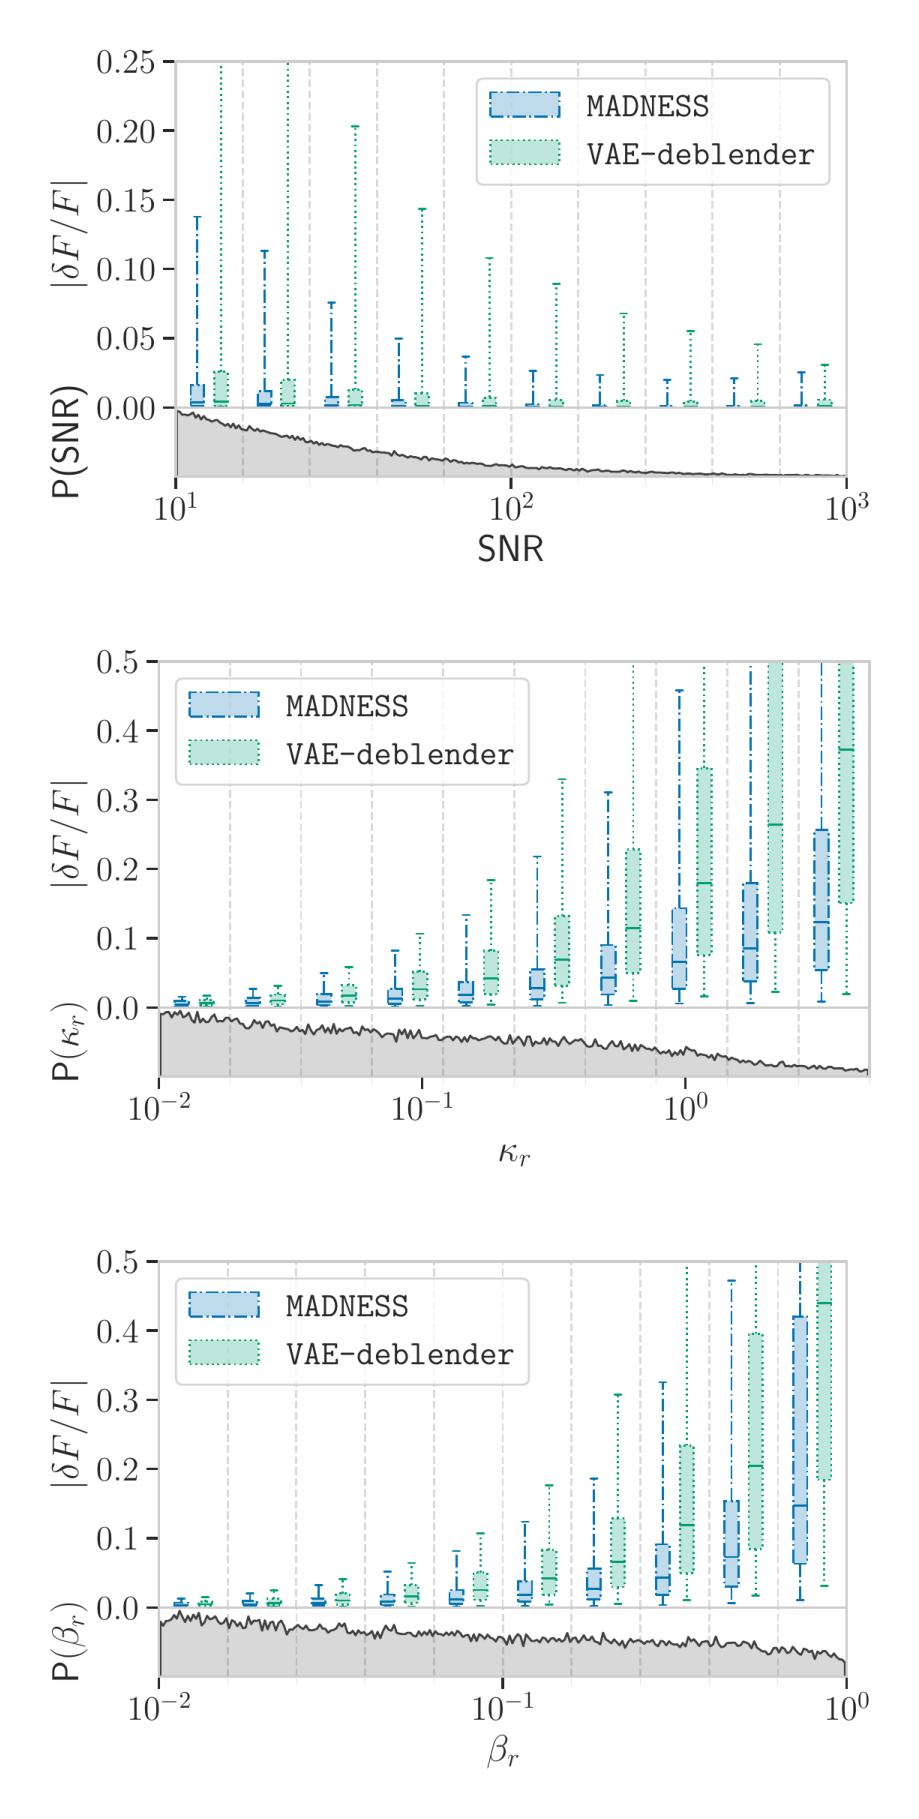

In [ ]:
f, axarr = plt.subplots(3, 1, figsize=(12, 18))


# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_pth, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(
    convert_from_path(os.path.join("results", "temp", "snr_box_plot.pdf"))[0]
)
axarr[1].imshow(
    convert_from_path(os.path.join("results", "temp", "contamination_box_plot.pdf"))[0]
)
axarr[2].imshow(
    convert_from_path(os.path.join("results", "temp", "blendedness_box_plot.pdf"))[0]
)

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
[ax.margins(y=0, x=0) for ax in axarr.ravel()]


plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", "boxplot_results.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()